# NYC Harasment Complaints Data Analysis

This notebook contains snippets that intend to dive into the [NYC Complaints data set](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-YTD/5uac-w243) and investigate trends of complaints about harasment (all records where PD_DESC ctonains the work HARASMENT). I am particulraly interested in seeing whether harasment in public places increased during the presidential election campaign and partiulary after the outcome of the presidential election.

In [1]:
# We will be using pandas for the number crunching and matplotlib for some basic charting
%matplotlib inline
import pandas
import folium
import matplotlib
import matplotlib.pyplot as plt

DATA_FILE_PATH = 'NYPD_Complaint_Data_Current_YTD.csv'

In [2]:
# We're parsing the csv data to a DataFrame, filter only records from 2016, parse the dates and add an integer for each record so it'll be easier to count each complaint
fullData = pandas.read_csv(DATA_FILE_PATH, sep=',')
fullData = fullData[fullData['CMPLNT_FR_DT'].str.contains("2016")==True]
fullData['CMPLNT_FR_DT'] = pandas.to_datetime(fullData['CMPLNT_FR_DT'])
fullData['COUNT'] = 1
print(str(len(fullData)) + ' records in the filtrered data set.')

468290 records in the filtrered data set.


First we look at the different description types of complaints in general in 2016:

There are 351 diffreent description types in the data set


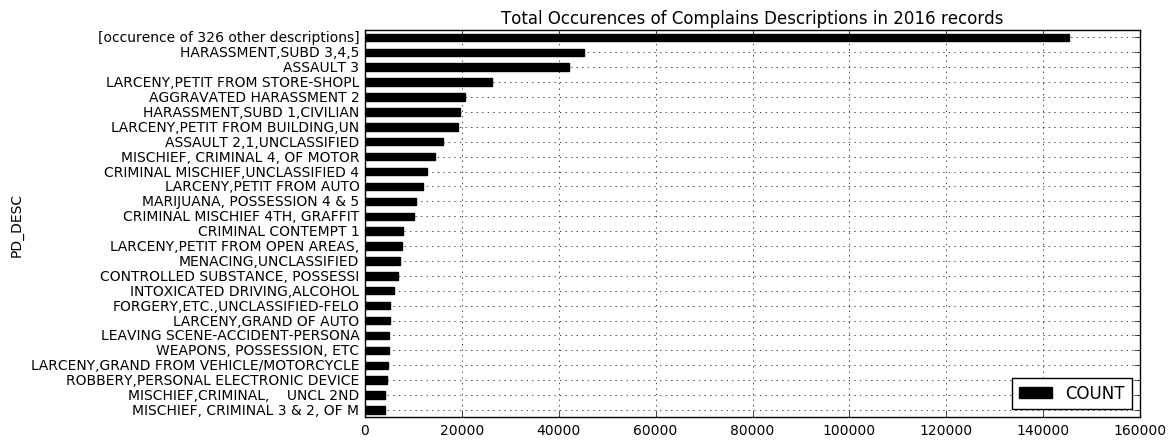

In [3]:
# summing all description types
descriptionTypeCount = len(fullData['PD_DESC'].value_counts())
print('There are ' + str(descriptionTypeCount) + ' diffreent description types in the data set')
descriptionAllTotals = pandas.DataFrame(fullData.groupby(['PD_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = descriptionTypeCount - head

# combining all description that aren't in the top records
descriptionAllTotals = descriptionAllTotals.sort_values(['COUNT'], ascending=False)
descriptionTopTotals = descriptionAllTotals.head(head).reset_index()
otherDescriptionsAmount = descriptionAllTotals.tail(tail)['COUNT'].sum()
otherDescriptionsRow = pandas.DataFrame([['[occurence of '+str(tail)+' other descriptions]', otherDescriptionsAmount]], columns=['PD_DESC', 'COUNT'])
descriptionTotals = descriptionTopTotals.append(otherDescriptionsRow)

# plot the description amounts
plt.rcParams["figure.figsize"] = [10,5]
descriptionTotals = descriptionTotals.sort_values(['COUNT'], ascending=True)
descriptionTotals = descriptionTotals.set_index('PD_DESC')
descriptionTotals.plot.barh(facecolor='k');
plt.title('Total Occurences of Complains Descriptions in 2016 records')
plt.grid()

Displaying the sum of all complaint types of 2016 in the chart above, we can see that harasment complaints are the most common complaint, particulary the 'HARASMENT,SUB 3,4,5' type. The other harasment type ('HARASMENT,SUBD 1,CILIVIAN) is the fith common complaint type in 2016. We can also see that there is a long tail of many different complaint types. 

In [4]:
# now we're digging down on the records that are about harasment in particular
harassmentData = fullData[fullData['PD_DESC'].str.contains("HARASSMENT")==True].sort_values(['CMPLNT_FR_DT'])

There are 70 diffreent location types in the data set


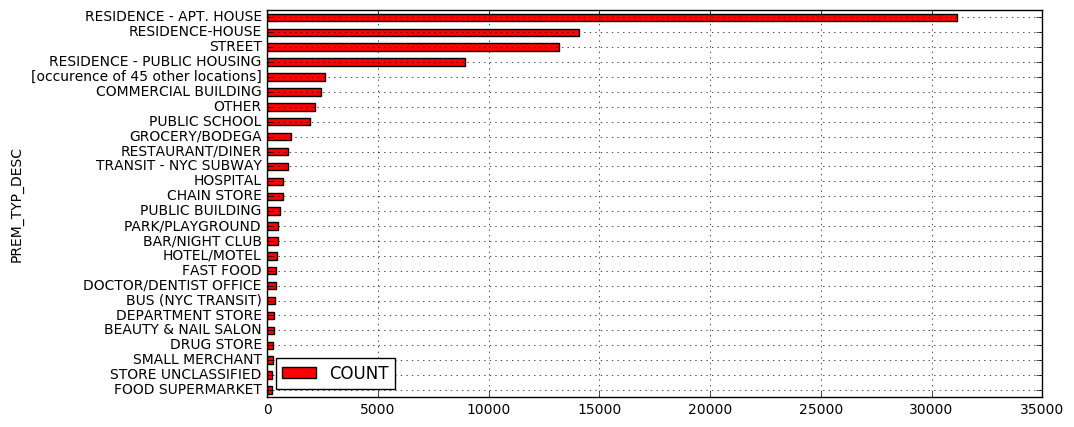

In [5]:
locationTypeCount = len(harassmentData['PREM_TYP_DESC'].value_counts())
print('There are ' + str(locationTypeCount) + ' diffreent location types in the data set')

harassmentDataTotals = pandas.DataFrame(harassmentData.groupby(['PREM_TYP_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = locationTypeCount - head

# combining all location types that aren't in the top records
harassmentDataTotals = harassmentDataTotals.sort_values(['COUNT'], ascending=False)
harassmentDataTopTotals = harassmentDataTotals.head(25)
otherLocationAmount = harassmentDataTotals.tail(locationTypeCount-25)['COUNT'].sum()
otherLocationRow = pandas.DataFrame([['[occurence of '+str(tail)+' other locations]', otherLocationAmount]], columns=['PREM_TYP_DESC', 'COUNT']).set_index('PREM_TYP_DESC')
harassmentDataFilteredTotals = harassmentDataTopTotals.append(otherLocationRow)

# plot the location amounts
plt.rcParams["figure.figsize"] = [10,5]
harassmentDataFilteredTotals = harassmentDataFilteredTotals.sort_values(['COUNT'], ascending=True)
harassmentDataFilteredTotals.plot.barh(facecolor='r');
plt.grid()

Breaking harasment complaints down by their reported location, we can see that the vast majroity of harasment appears to happen within a residential house or apartment. "Street" is third most common location reported harasment appears to take place.

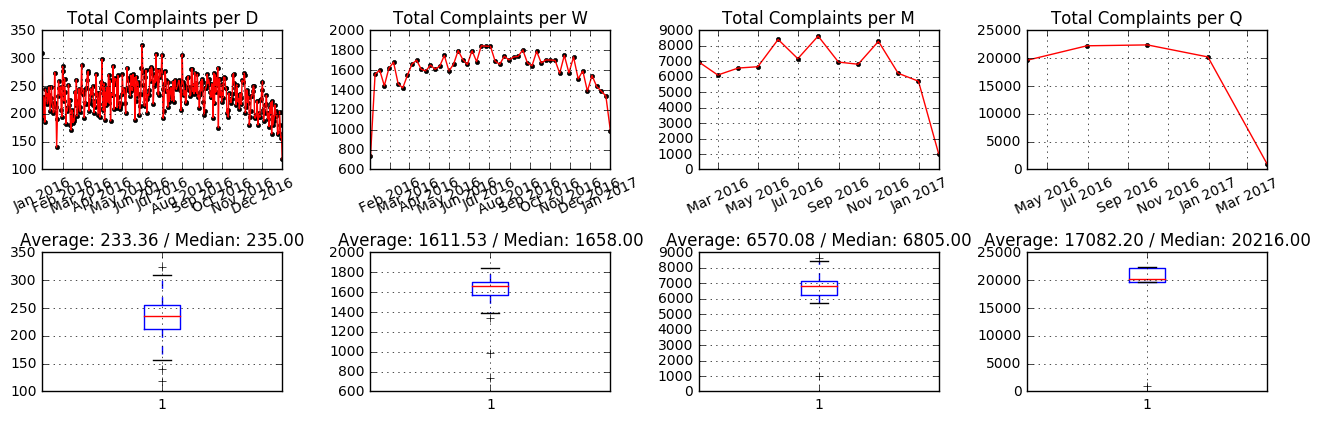

In [6]:
plt.rcParams["figure.figsize"] = [13,13]

harassmentDataTimeSeries = pandas.DataFrame(harassmentData.groupby(['CMPLNT_FR_DT','PREM_TYP_DESC'])['COUNT'].sum()).reset_index()
harassmentDataTimeSeries = harassmentDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
monthlyHarassmentDataTimeSeries = harassmentDataTimeSeries.set_index('CMPLNT_FR_DT')
timeAggs = ['D','W','M','Q']
i = 1

for timeAgg in timeAggs:
    monthlyHarassmentDataTimeSeries = monthlyHarassmentDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=25)
    plt.title('Total Complaints per '+timeAgg)
    plt.plot(monthlyHarassmentDataTimeSeries, 'k.', monthlyHarassmentDataTimeSeries, 'r-')
    plt.grid()
    plt.subplot(6, 4, i+4)
    plt.tight_layout()
    plt.boxplot(monthlyHarassmentDataTimeSeries['COUNT'])
    plt.title('Average: '+str('%.2f' % monthlyHarassmentDataTimeSeries.mean().COUNT)+' / Median: '+str('%.2f' % monthlyHarassmentDataTimeSeries.median().COUNT))
    plt.grid()
    i+=1

Looking at the weekly and monthly trends and means, we can see that there are on average 235 harasment complaints each day, 1612 each week and 6446 every month. August has been the month with the most harasment complaints in 2016 so far. There does not seem to be an increase between Q2 and Q3 and we have no data for Q4 yet.

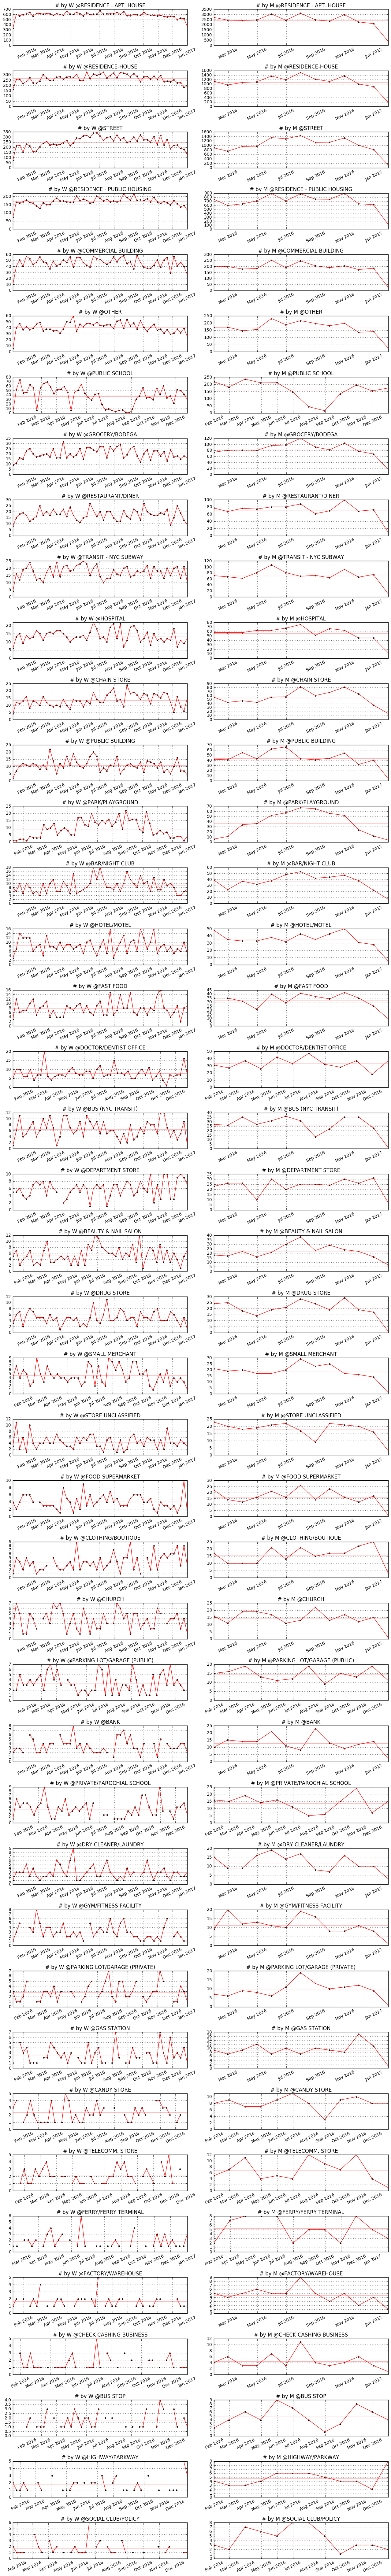

In [7]:
descArr = harassmentDataTotals.reset_index()['PREM_TYP_DESC'].tolist()
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
timeAggs = ['W','M']
i = 1

for desc in descArr:
    tempDF = pandas.DataFrame(harassmentDataTimeSeries[(harassmentDataTimeSeries['PREM_TYP_DESC'] == desc)]) 
    if(tempDF.COUNT.sum() > 50):
        tempDF = tempDF.set_index('CMPLNT_FR_DT')
        for timeAgg in timeAggs:    
            tempDF = tempDF.resample(timeAgg).sum()
            plt.subplot(len(descArr), 2, i)
            plt.tight_layout()
            plt.plot(tempDF, 'k.', tempDF, 'r-')
            plt.title('# by '+timeAgg+' @'+desc)
            plt.ylim(ymin=0)
            plt.xticks(rotation=25)
            plt.grid()
            plt.axhline(tempDF.COUNT.mean(), color='red', alpha=0.3)
            i+=1

Digging through the small multiples above that show the weekly and monthly trend of harasment complaints for each location, we can see that most amounts stay relatively consistent over time. However, '**Street**' and '**Playground**' seem to be have been rising throughout the year.

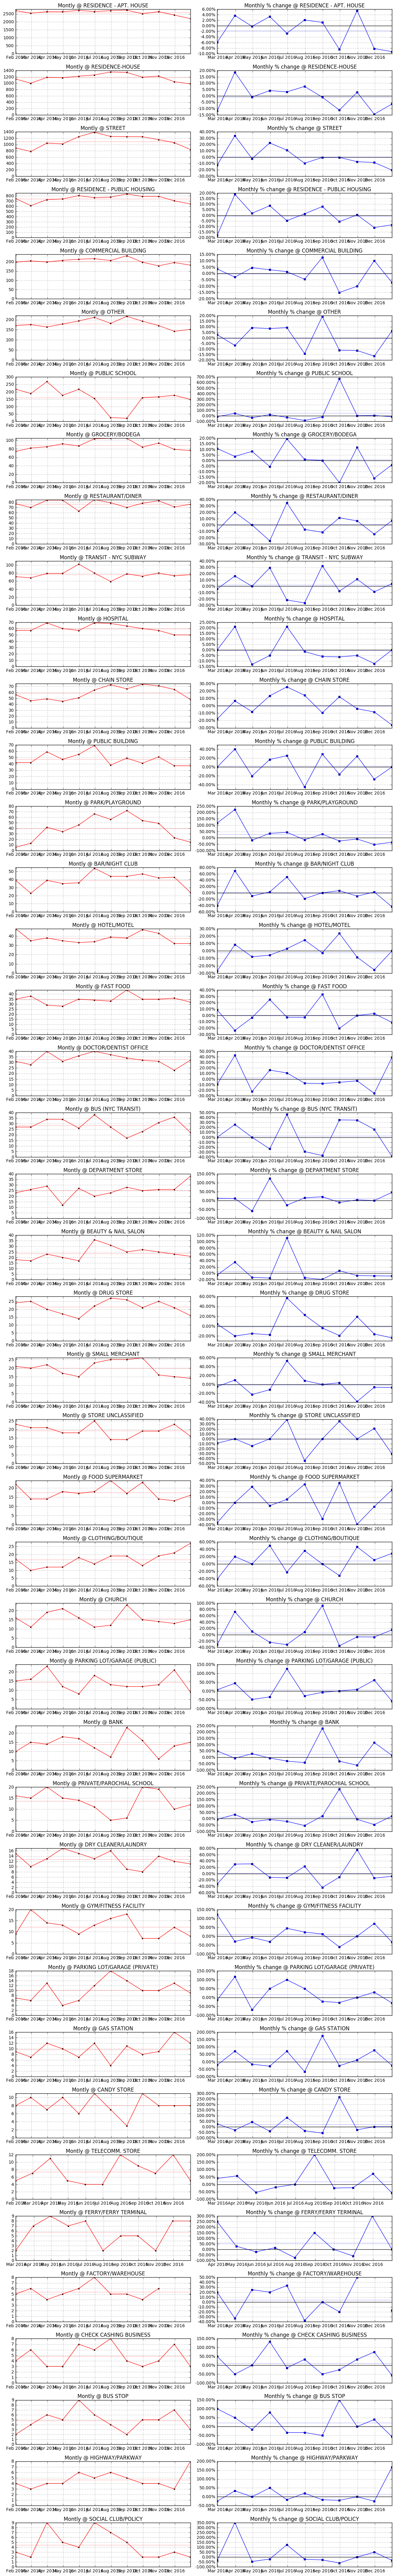

In [8]:
descArr = harassmentDataTotals.reset_index()['PREM_TYP_DESC'].tolist()
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
i = 1

for desc in descArr:
    tempDF = pandas.DataFrame(harassmentDataTimeSeries[(harassmentDataTimeSeries['PREM_TYP_DESC'] == desc)]) 
    if(tempDF.COUNT.sum() > 50):
        tempDF = tempDF.set_index('CMPLNT_FR_DT')
        tempDF = tempDF.resample("M").sum()
        plt.subplot(len(descArr), 2, i)
        plt.tight_layout()
        plt.plot(tempDF, 'k.', tempDF, 'r-')
        plt.title('Montly @ ' + desc)
        plt.ylim(ymin=0)
        plt.grid()
        plt.axhline(tempDF.COUNT.mean(), color='red', alpha=0.3)
        i+=1       
        tempDF = tempDF.pct_change();
        ax = plt.subplot(len(descArr), 2, i)
        plt.plot(tempDF, 'bs', tempDF, 'b-', markersize=5)
        plt.title('Monthly % change @ ' + desc)
        plt.grid()
        plt.axhline(0, color='black')
        plt.axhline(tempDF.COUNT.mean(), color='blue', alpha=0.3)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        i+=1

In [9]:
streetHarassmentData = harassmentData[harassmentData['PREM_TYP_DESC'] == 'STREET']
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()
streetHarassmentData = streetHarassmentData.round(2)
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()

map_2 = folium.Map(location=[40.729771, -73.997263], tiles='Stamen Toner', zoom_start=11)
lat_list = streetHarassmentData['Latitude'].tolist()
lon_list = streetHarassmentData['Longitude'].tolist()
con_list = streetHarassmentData['COUNT'].tolist()

for i in range(0, len(lat_list)):
    folium.CircleMarker(
        location=[lat_list[i],lon_list[i]], 
        radius=con_list[i]*10, 
        color='#8B0000', 
        fill_color='#8B0000'
    ).add_to(map_2)       

map_2